In [4]:
import pandas as pd # 主要資料型態為series以及dataframe，功能以numpy為基礎再延伸更多進階的操作
import numpy as np # 操作陣列型態資料的套件
import matplotlib.pyplot as plt # 基本的繪圖套件
import seaborn as sns # 基於matplotlib提供更多高階視覺化的套件

from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV

import warnings
plt.style.use('ggplot')
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
# 可以用pandas裡面的函式來讀取csv檔，使用方法為pd.read_csv('檔案名稱')

# 訓練資料
train = pd.read_csv("train/train.csv") 

# 測試資料
test = pd.read_csv("test/test.csv") 

# 將訓練及測試資料結合以利後續的資料前處理
data = train.append(test) 
data.reset_index(inplace=True, drop=True)

# 使用type()查看物件的型態，可以確認我們讀取後的檔案型態為datarframe
type(test)

pandas.core.frame.DataFrame

### 1.1 觀察資料

In [3]:
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [4]:
train.shape

(891, 12)

In [5]:
test.shape

(418, 11)

In [6]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [7]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [8]:
train.describe(include=['O']) 

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Andrews, Mr. Thomas Jr",male,CA. 2343,B96 B98,S
freq,1,577,7,4,644


In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [10]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [11]:
test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [12]:
# 觀察性別與存活率之間的關聯，使用mean來觀察Sex中男女的平均存活率，依照高至低排列
train[['Sex', 'Survived']].groupby('Sex').mean().sort_values(by = 'Survived', ascending = False)

,Survived
Sex,
female,0.742038
male,0.188908


In [13]:
# 觀察艙房等級與存活率之間的關聯，使用mean來觀察Pclass中各類label的平均存活率，依照高至低排列
train[['Pclass','Survived']].groupby('Pclass').mean().sort_values(by = 'Survived', ascending = False)

,Survived
Pclass,
1,0.629630
2,0.472826
3,0.242363


In [14]:
# 觀察兄弟姐妹+配偶數量與存活率之間的關聯，依照高至低排列
train[['SibSp', 'Survived']].groupby('SibSp').mean().sort_values(by = 'Survived', ascending = False) 

,Survived
SibSp,
1,0.535885
2,0.464286
0,0.345395
3,0.250000
4,0.166667
5,0.000000
8,0.000000


In [15]:
# 觀察雙親+子女數量與存活率之間的關聯，依照高至低排列
train[['Parch', 'Survived']].groupby('Parch').mean().sort_values(by = 'Survived', ascending = False ) 

,Survived
Parch,
3,0.600000
1,0.550847
2,0.500000
0,0.343658
5,0.200000
4,0.000000
6,0.000000


### 1. 2 資訊視覺化

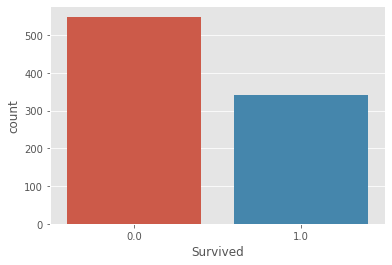

In [16]:
# 觀察死亡與存活的比例
sns.countplot(data['Survived']) 

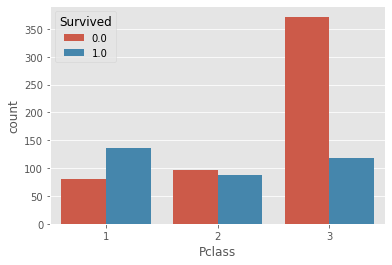

In [17]:
# 觀察船倉與存活的比例
sns.countplot(data['Pclass'] , hue = data['Survived'])

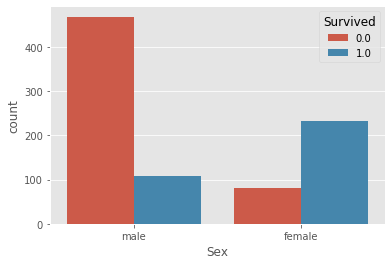

In [18]:
# 觀察性別與存活的比例
sns.countplot(data["Sex"] , hue = data["Survived"])

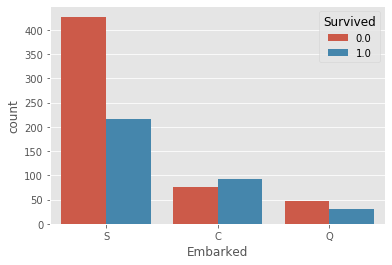

In [19]:
# 觀察出發港口與存活的比例
sns.countplot(data['Embarked'] , hue = data['Survived'])

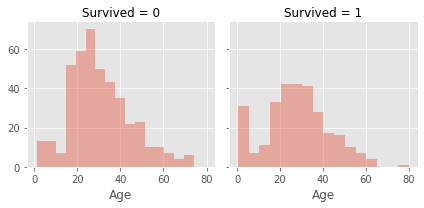

In [20]:
# 年齡與生存率的關係

# col參數用來設定在該特徵條件下，畫出的圖以欄的方式排列
g = sns.FacetGrid(train, col = 'Survived')

# distplot表示直方圖
g.map(sns.distplot, 'Age', kde = False)

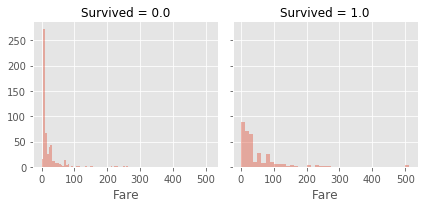

In [21]:
# 票價與生存率的關係
g = sns.FacetGrid(data , col = "Survived")
g.map(sns.distplot , 'Fare' , kde = False)

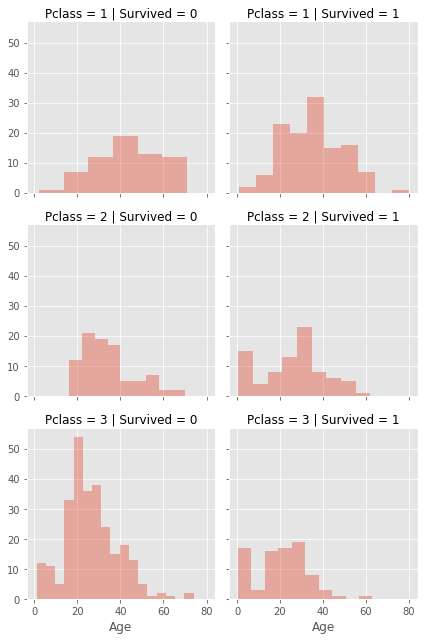

In [22]:
# 各艙房幸存者與罹難者的乘客年齡分佈

# 觀察各艙房生存與死亡的乘客年齡分佈 
g = sns.FacetGrid(train, col = 'Survived', row = 'Pclass') 

# row參數用來設定在該特徵條件下，畫出的圖以列的方式排列
g.map(sns.distplot, 'Age', kde = False) 

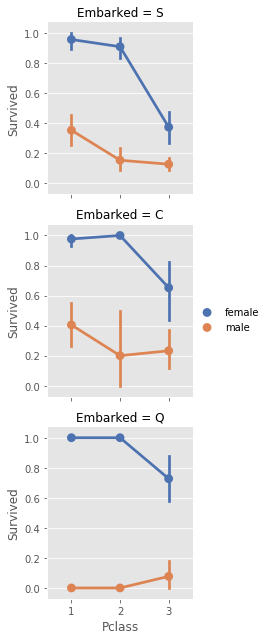

In [23]:
# 觀察各港口登船的男、女乘客他們所住的艙房與生存率之間的關聯

# 圖裡用到三個特徵，第一個表示x軸，第二個表示y軸，第三個則是用顏色(hue)表示類別的差異，palette是顏色的深淺，hue_order用來指定類別順序
g = sns.FacetGrid(train, row = 'Embarked')
g.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette = 'deep', hue_order=["female", "male"]) 
# add_legend可以顯示圖例
g.add_legend() 

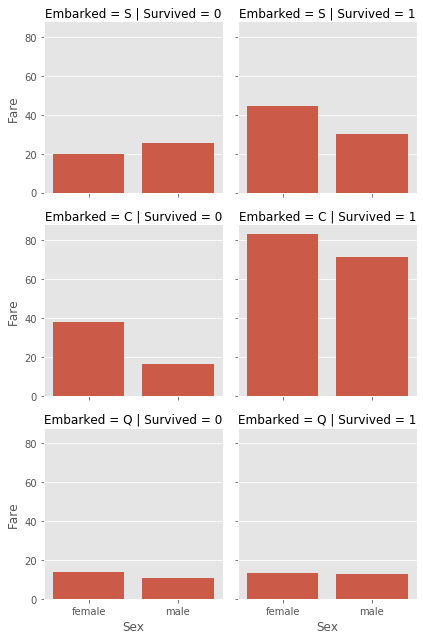

In [24]:
# 觀察各港口登船、罹難或倖存的乘客們的票價與性別之間的關聯

g = sns.FacetGrid(train, row = 'Embarked', col = 'Survived')
# ci = None用來取消信賴區間線
g.map(sns.barplot, 'Sex', 'Fare', ci = None) 

### 特徵轉換&資料前處理

In [26]:
# 使用shape()函式，可以看到train data與test data資料表的row與column數量
combine = [train, test]
print("Before", train.shape, test.shape, combine[0].shape , combine[1].shape)

train = train.drop(['Ticket', 'Cabin'],axis=1)
test = test.drop(['Ticket', 'Cabin'],axis=1) 
combine = [train, test]

"After", train.shape, test.shape, combine[0].shape , combine[1].shape

Before (891, 12) (418, 11) (891, 12) (418, 11)


('After', (891, 10), (418, 9), (891, 10), (418, 9))

In [27]:
# 首先從乘客名字裡建立一個新的特徵"Titile"，Title是乘客的頭銜，它隱含著乘客的性別、婚姻狀況甚至是社經地位等。

# 用正規表達式將Title從Name裡面析取出來
for dataset in combine:
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
    
# 觀察Title與性別之間的分佈
pd.crosstab(train['Title'], train['Sex'])

Sex,female,male
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


In [28]:
# 將Title這個特徵從文字轉換成類別資料，從上個步驟發現，大部分的Title數量其實很少，於是可以將這些數量過少的歸類成Rare

# 用dictionary的方法可以將key(Title)映射(mapping)至對應的value(類別資料)
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
for dataset in combine:
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)

train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,1.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,3.0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,2.0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,3.0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,1.0


In [29]:
# 轉換完之後將Name這個特徵丟掉，因為我們已經從它析取出可用的資訊了

train = train.drop(['Name', 'PassengerId'], axis=1)
# 用drop丟掉Name, axis=1表示column，axis=0則表示row
test = test.drop(['Name'], axis=1) 
combine = [train, test]
train.shape, test.shape

((891, 9), (418, 9))

In [30]:
for dataset in combine:
    dataset['Sex'] = dataset['Sex'].map( {'female': 1, 'male': 0} ).astype(int)

train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,0,22.0,1,0,7.2500,S,1.0
1,1,1,1,38.0,1,0,71.2833,C,3.0
2,1,3,1,26.0,0,0,7.9250,S,2.0
3,1,1,1,35.0,1,0,53.1000,S,3.0
4,0,3,0,35.0,0,0,8.0500,S,1.0


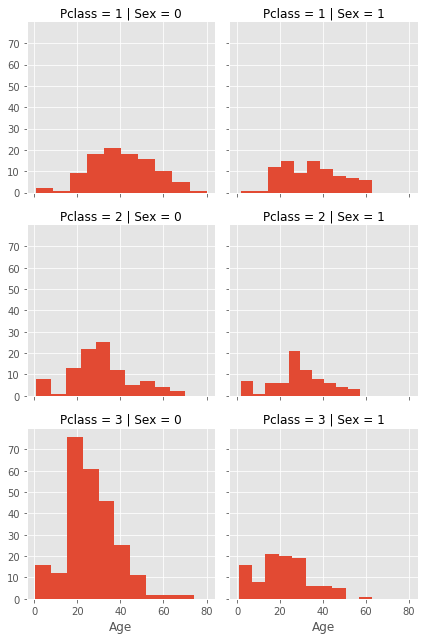

In [31]:
# 觀察各艙房中男女乘客的年齡分佈(Age)
g = sns.FacetGrid(train, row='Pclass', col='Sex') 
g.map(plt.hist, 'Age')

In [33]:
# 依照艙房等級與性別來補足年齡的缺值

# np.zeros可用來建構0的陣列，(2,3)是參數shape的值，可視為2*3的矩陣
guess_ages = np.zeros((2,3)) 

# 將用這個矩陣存取用來補足缺值的值
guess_ages 


for dataset in combine:
    for i in range(0, 2): # 性別
        for j in range(0, 3): # 艙房等級
            guess = dataset[(dataset['Sex'] == i) & \
                                  (dataset['Pclass'] == j+1)]['Age'].dropna() # 將艙房與性別的缺值去除

            age_guess = guess.median() # 從去除缺值後的資料中選出中位數

            guess_ages[i,j] = round(age_guess) # 將中位數四捨五入
            
    for i in range(0, 2):
        for j in range(0, 3):
            dataset.loc[ (dataset.Age.isnull()) & (dataset.Sex == i) & (dataset.Pclass == j+1),\
                    'Age'] = guess_ages[i,j] # 將有缺值的地方補上中位數

    dataset['Age'] = dataset['Age'].astype(int) # 將年齡轉換成整數型態

train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,0,22,1,0,7.2500,S,1.0
1,1,1,1,38,1,0,71.2833,C,3.0
2,1,3,1,26,0,0,7.9250,S,2.0
3,1,1,1,35,1,0,53.1000,S,3.0
4,0,3,0,35,0,0,8.0500,S,1.0


In [34]:
# 處理完年齡缺值後，接著轉換成類別型態的資料，也就是以年齡的區間表示年齡，這有助於更容易觀察年齡與存活率的關係

# pd.cut可以將連續型的數值資料均分成指定的數量，例如這邊想將年齡做5等分
train['AgeBand'] = pd.cut(train['Age'], 5) 

# 觀察每個年齡區間的存活率
train[['AgeBand', 'Survived']].groupby(['AgeBand'], as_index=False).mean().sort_values(by='AgeBand', ascending=True)

,AgeBand,Survived
0,"(-0.08, 16.0]",0.550000
1,"(16.0, 32.0]",0.337374
2,"(32.0, 48.0]",0.412037
3,"(48.0, 64.0]",0.434783
4,"(64.0, 80.0]",0.090909


In [35]:
# 依照算出來的年齡區間將年齡轉換成類別資料

for dataset in combine:    
    # loc這個函式可以找出符合[]內條件的資料
    # 將符合該區間的年齡找出並以相應的類別取代
    dataset.loc[ dataset['Age'] <= 16, 'Age'] = 0 
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age']
train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,AgeBand
0,0,3,0,1,1,0,7.2500,S,1.0,"(16.0, 32.0]"
1,1,1,1,2,1,0,71.2833,C,3.0,"(32.0, 48.0]"
2,1,3,1,1,0,0,7.9250,S,2.0,"(16.0, 32.0]"
3,1,1,1,2,1,0,53.1000,S,3.0,"(32.0, 48.0]"
4,0,3,0,2,0,0,8.0500,S,1.0,"(32.0, 48.0]"


In [36]:
# 將轉換完類別資料之後，將不需要的年齡區間丟掉

train = train.drop(['AgeBand'], axis=1)
combine = [train, test]
train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,0,1,1,0,7.2500,S,1.0
1,1,1,1,2,1,0,71.2833,C,3.0
2,1,3,1,1,0,0,7.9250,S,2.0
3,1,1,1,2,1,0,53.1000,S,3.0
4,0,3,0,2,0,0,8.0500,S,1.0


In [37]:
for dataset in combine:
    # 計算家庭大小，+1表示乘客本人也算在內
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1 

# 觀察家庭大小與存活率的關係
train[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).mean().sort_values(by='Survived', ascending=False)


,FamilySize,Survived
3,4,0.724138
2,3,0.578431
1,2,0.552795
6,7,0.333333
0,1,0.303538
4,5,0.200000
5,6,0.136364
7,8,0.000000
8,11,0.000000


In [38]:
# 觀察家庭大小跟存活率的關係之後，發現兩者間並無明顯關係，因此我們嘗試可將此特徵轉換成"IsAlone"，表示乘客是否單身搭乘
for dataset in combine:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1

train[['IsAlone', 'Survived']].groupby(['IsAlone'], as_index=False).mean()

,IsAlone,Survived
0,0,0.505650
1,1,0.303538


In [39]:
# 接著就可以丟掉Parch, SibSp和FamilySize這些特徵
train = train.drop(['Parch', 'SibSp', 'FamilySize'], axis=1)
test = test.drop(['Parch', 'SibSp', 'FamilySize'], axis=1)
combine = [train, test]

train.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone
0,0,3,0,1,7.2500,S,1.0,0
1,1,1,1,2,71.2833,C,3.0,0
2,1,3,1,1,7.9250,S,2.0,1
3,1,1,1,2,53.1000,S,3.0,0
4,0,3,0,2,8.0500,S,1.0,1


In [40]:
for dataset in combine:
    dataset['Age*Class'] = dataset.Age * dataset.Pclass

train.loc[:, ['Age*Class', 'Age', 'Pclass']].head(10)

,Age*Class,Age,Pclass
0,3,1,3
1,2,2,1
2,3,1,3
3,2,2,1
4,6,2,3
5,3,1,3
6,3,3,1
7,0,0,3
8,3,1,3
9,0,0,2


In [41]:
# 使用mode可以找出資料中最常見的值

freq_port = train.Embarked.dropna().mode()[0] 
freq_port
for dataset in combine:
    # 將缺值以最常見的值補上
    dataset['Embarked'] = dataset['Embarked'].fillna(freq_port)

# 觀察搭乘港口與存活率關係
train[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean().sort_values(by='Survived', ascending=False)


,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.339009


In [42]:
for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
train.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone,Age*Class
0,0,3,0,1,7.2500,0,1.0,0,3
1,1,1,1,2,71.2833,1,3.0,0,2
2,1,3,1,1,7.9250,0,2.0,1,3
3,1,1,1,2,53.1000,0,3.0,0,2
4,0,3,0,2,8.0500,0,1.0,1,6


In [43]:
test['Fare'].fillna(test['Fare'].dropna().median(), inplace=True)
test.head()

,PassengerId,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone,Age*Class
0,892,3,0,2,7.8292,2,1.0,1,6
1,893,3,1,2,7.0000,0,3.0,0,6
2,894,2,0,3,9.6875,2,1.0,1,6
3,895,3,0,1,8.6625,0,1.0,1,3
4,896,3,1,1,12.2875,0,3.0,0,3


In [44]:
# 將票價分成四等分區間
train['FareBand'] = pd.qcut(train['Fare'], 4)

# 觀察各區間的存活率
train[['FareBand', 'Survived']].groupby(['FareBand'], as_index=False).mean().sort_values(by='FareBand', ascending=True)

,FareBand,Survived
0,"(-0.001, 7.91]",0.197309
1,"(7.91, 14.454]",0.303571
2,"(14.454, 31.0]",0.454955
3,"(31.0, 512.329]",0.581081


In [45]:
for dataset in combine:
    # 將每個區間的票價轉換成類別型態
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)

train = train.drop(['FareBand'], axis=1) # 轉換完成後丟掉票價區間
combine = [train, test] # 將train與test合併
    
train.head(10)

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone,Age*Class
0,0,3,0,1,0,0,1.0,0,3
1,1,1,1,2,3,1,3.0,0,2
2,1,3,1,1,1,0,2.0,1,3
3,1,1,1,2,3,0,3.0,0,2
4,0,3,0,2,1,0,1.0,1,6
5,0,3,0,1,1,2,1.0,1,3
6,0,1,0,3,3,0,1.0,1,3
7,0,3,0,0,2,0,4.0,0,0
8,1,3,1,1,1,0,3.0,0,3
9,1,2,1,0,2,1,3.0,0,0


### 擬合模型

In [1]:
train.to_excel('train/train_new.xls')

NameError: name 'train' is not defined

In [2]:
test.to_excel('test/test_new.xls')

NameError: name 'test' is not defined

In [5]:
# 訓練資料
train = pd.read_excel("train/train_new.xls") 

# 測試資料
test = pd.read_excel("test/test_new.xls") 

In [6]:
X_train = train.drop("Survived", axis=1)
Y_train = train["Survived"]
X_test  = test.drop("PassengerId", axis=1).copy()
X_train.shape, Y_train.shape, X_test.shape

((891, 9), (891,), (418, 9))

In [7]:
# 機器學習模組 machine learning

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

In [8]:
logreg = LogisticRegression()

# 用train資料來訓練模型
logreg.fit(X_train, Y_train)

# 評估準確率須使用test資料
Y_pred = logreg.predict(X_test) 

# 將準確率轉換成百分制並且取到小數點後兩位
acc_log = round(logreg.score(X_train, Y_train)*100 , 2) 
acc_log

80.7

In [9]:
# neighbor數目可以自己調整，找出最好的參數

knn = KNeighborsClassifier(n_neighbors = 3) 
knn.fit(X_train, Y_train)
Y_pred = knn.predict(X_test)
acc_knn = round(knn.score(X_train, Y_train) * 100, 2)
acc_knn

81.59

In [10]:
svc = SVC()
svc.fit(X_train, Y_train)
Y_pred = svc.predict(X_test)
acc_svc = round(svc.score(X_train, Y_train)*100,2)
acc_svc

96.41

In [11]:
gnb = GaussianNB()
gnb.fit(X_train, Y_train)
Y_pred = gnb.predict(X_test)
acc_gnb = round(gnb.score(X_train, Y_train)*100, 2)
acc_gnb

73.51

In [12]:
perceptron = Perceptron()
perceptron.fit(X_train, Y_train)
Y_pred = perceptron.predict(X_test)
acc_perceptron = round(perceptron.score(X_train, Y_train)*100, 2)
acc_perceptron

39.17

In [13]:
linear_svc = LinearSVC()
linear_svc.fit(X_train, Y_train)
Y_pred = linear_svc.predict(X_test)
acc_linear_svc = round(linear_svc.score(X_train, Y_train) * 100, 2)
acc_linear_svc

79.69

In [14]:
sgd = SGDClassifier()
sgd.fit(X_train, Y_train)
Y_pred = sgd.predict(X_test)
acc_sgd = round(sgd.score(X_train, Y_train) * 100, 2)
acc_sgd

62.07

In [15]:
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, Y_train)
Y_pred = decision_tree.predict(X_test)
acc_decision_tree = round(decision_tree.score(X_train, Y_train) * 100, 2)
acc_decision_tree

100.0

In [16]:
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, Y_train)
Y_pred = random_forest.predict(X_test)
random_forest.score(X_train, Y_train)
acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)
acc_random_forest

100.0

In [17]:
models = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes', 'Perceptron', 
              'Stochastic Gradient Decent', 'Linear SVC', 
              'Decision Tree'],
    'Score': [acc_svc, acc_knn, acc_log, 
              acc_random_forest, acc_gnb, acc_perceptron, 
              acc_sgd, acc_linear_svc, acc_decision_tree]})
models.sort_values(by='Score', ascending=False)

,Model,Score
3,Random Forest,100.00
8,Decision Tree,100.00
0,Support Vector Machines,96.41
1,KNN,81.59
2,Logistic Regression,80.70
7,Linear SVC,79.69
4,Naive Bayes,73.51
6,Stochastic Gradient Decent,62.07
5,Perceptron,39.17
